## Load, check, and record configuration

In [1]:
import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt
import yaml
import time
import pickle as pkl
import os
import numpy as np
from matplotlib import cm
from scipy.signal import welch,periodogram
import pandas as pd
import glob
from scipy.optimize import curve_fit
from scipy import signal

import pysmurf.client
import matplotlib.pylab as plt
import numpy as np
import sys
import os
epics_prefix="smurf_server_s4"
config_file  = "/usr/local/src/pysmurf/cfg_files/slab/experiment_b33_C03-A03-06_bfg_squats.cfg"
S = pysmurf.client.SmurfControl(epics_root=epics_prefix,cfg_file=config_file,setup=False,make_logfile=False,shelf_manager="shm-smrf-sp01")

What versions of everything are we running?

In [2]:
pysmurf.__version__

'8.0.0+23.g1a5857e6.dirty'

In [3]:
!git branch

  main
* squat_attempt1
  zoekid


In [4]:
S._caget(f'{epics_prefix}:AMCc:RogueVersion', as_string=True)

'v4.11.11'

In [5]:
S._caget(f'{epics_prefix}:AMCc:SmurfApplication:SmurfVersion', as_string=True)

'8.0.0'

In [6]:
S._caget(f'{epics_prefix}:AMCc:SmurfApplication:StartupArguments', as_string=True)

'-w smurf_server_s4 -e smurf_server_s4 -z /tmp/fw/rogue_v2.1.0.zip -l 2 -a 10.0.1.104 --disable-bay1 -d /tmp/fw/smurf_cfg/defaults/defaults_c03_tkid_none.yml'

In [7]:
S.get_fpga_git_hash_short()

'ec69acf'

`shawnhammer` ran `setup()` already.  Make sure JESD is locked:

In [8]:
S.check_jesd(0)

[ 2025-09-19 00:19:54 ]  JESD Tx Okay
[ 2025-09-19 00:19:54 ]  JESD Rx Okay
[ 2025-09-19 00:19:56 ]  JESD health check finished after 1 seconds. The final status was Locked.


(True, True, 'Locked')

Check communication with cryocard and its fw version

What hardware are we using?  use_shell=True is slower but doesn't require the atca_monitor docker.

In [9]:
S.get_carrier_sn(use_shell=True)

'C01-A01-05'

In [10]:
S.get_rtm_sn(use_shell=True)

[ 2025-09-19 00:20:04 ]  ERROR : RTM FRU information incomplete or missing "Product Version" and/or "Product Asset Tag" fields.  Returning None.


In [11]:
S.get_amc_sn(0,use_shell=True)

'C03-C03-A03-06'

# Single channel

SQUAT data taking has been using `take_debug_data` like this (from https://github.com/DMQIS/SQUAT_DAQ/blob/main/Measurements/SMURF/daily_logs/2025_0818_alex_and_hannah_starting.ipynb);

In [12]:
def welch_IQ(iq, fs,  plot=True, welch_nperseg=2**18, title='', show_plot=True):
    i = iq.real
    q = iq.imag
    ffi, pxxi = welch(i,fs=fs, nperseg=welch_nperseg)
    ffq, pxxq = welch(q,fs=fs, nperseg=welch_nperseg)

    # scale to dBc/Hz by the voltage magnitude
    magfac = np.mean(q)**2 + np.mean(i)**2
    pxxi_dbc = 10. * np.log10(pxxi / magfac)
    pxxq_dbc = 10. * np.log10(pxxq / magfac)


    if plot:
        plt.gca().semilogx(ffi,pxxi_dbc,linestyle='-',label=f'i {title}')
        plt.gca().semilogx(ffq,pxxq_dbc, linestyle='--',label=f'q {title}')
        plt.ylabel('dBc/Hz')
        plt.xlabel('Frequency (Hz)')
        plt.title(title)
        plt.legend(loc='lower left')
        if show_plot: plt.show()
    return 0

def takeDebugData(S, band, channel, nsamp, plot=True, welch_nperseg=2**18, show_plot=True, channel_mode=2):
    timestamp = S.get_timestamp() 
    filename = f'{timestamp}_multi_channel_b{band}'
    if channel is not None:
        filename = f'{timestamp}_single_channel_b{band}ch{channel:03}'
    i,q,sync = S.take_debug_data(band=band,channel=channel,rf_iq=True,nsamp=nsamp,filename=filename, single_channel_readout=channel_mode) 
    i = i / (1.2)
    q = q / (-1.2)
    iq = i + 1j * q
    if plot: 
        fs = S.get_channel_frequency_mhz(band) * 1.0E6
        if channel_mode==1:
            fs/=2.
            fs/=(S.get_decimation(band)+1.)
        welch_IQ(iq, fs, welch_nperseg, title=filename, show_plot=show_plot)
        ### save plots 
        fig = plt.gcf()
        #plt.savefig(f'/data/smurf_data/mkid_1tone_streaming_metadata/_Figs/{filename}_psd', fmt='tiff')
        plt.show()
    return iq, sync, filename

Let's work first with a tone in the center of band 0.

In [13]:
S.get_band_center_mhz(0)

4250.0

In [14]:
S.which_bands()

[0, 1, 2, 3, 4, 5, 6, 7]

In [15]:
try:
    band,channel=S.set_fixed_tone(S.get_band_center_mhz(0),12)
except:
    #If set_fixed_tone raises an exception, turn off bands first
    for band in S.which_bands():
        for chan in S.which_on(band):
            S.set_amplitude_scale_channel(band, chan, 0)
    band,channel=S.set_fixed_tone(S.get_band_center_mhz(0),12)

In [16]:
#band,channel=S.set_fixed_tone(S.get_band_center_mhz(0),12)

In [17]:
print("bands:", band)
print("channel:", channel)
print("which_bands:", S.which_bands())
print("which_on(band):", S.which_on(band))
print("diff:", np.diff(S.which_on(band)))
subband, foff = S.freq_to_subband(band, S.get_band_center_mhz(0))
print("subband:", subband)
subband_channels = S.get_channels_in_subband(band, subband)
print("subband_channels:", subband_channels)
print("get num processed channels:", S.get_number_processed_channels(band))
print("\n")

bands: 0
channel: 0
which_bands: [0, 1, 2, 3, 4, 5, 6, 7]
which_on(band): [0]
diff: []
subband: 255
subband_channels: [0]
get num processed channels: 416




In [18]:
S.set_fixed_tone??

Signature: S.set_fixed_tone(freq_mhz, tone_power, write_log=False)
Source:   
    def set_fixed_tone(self, freq_mhz, tone_power, write_log=False):
        """
        Places a fixed tone at the requested frequency.  Asserts
        without doing anything if the requested resonator frequency
        falls outside of the usable 500 MHz bands, or if there are no
        unassigned channels available in the subband the requested
        frequency falls into (where a channel is deemed "assigned" if
        it has non-zero amplitude).

        Args
        ----
        freq_mhz : float
            The frequency in MHz at which to place a fixed tone.
        tone_power : int
            The amplitude for the fixed tone (0-15 in recent fw
            revisions).
        write_log : bool, optional, default False
            Whether to write low-level commands to the log file.

        Returns
        -------
        band : int
            The band number in which a tone was turned on.
        c

Try taking data the usual way

[ 2025-09-19 00:20:15 ]  caput smurf_server_s4:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[0]:readoutChannelSelect 0
[ 2025-09-19 00:20:15 ]  Writing to file : /data/smurf_data/20250919/1758241193/outputs/1758241215_single_channel_b0ch000.dat
[ 2025-09-19 00:20:15 ]  caput smurf_server_s4:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 33554432
[ 2025-09-19 00:20:15 ]  caput smurf_server_s4:AMCc:FpgaTopLevel:AppTop:AppCore:DebugSelect[0] 0
[ 2025-09-19 00:20:15 ]  Data acquisition in progress...
[ 2025-09-19 00:20:15 ]  caput smurf_server_s4:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:TriggerDaq 1
[ 2025-09-19 00:20:32 ]  Done taking data


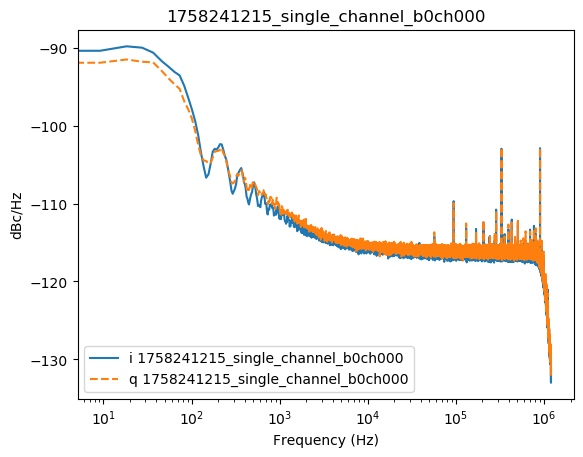

<Figure size 640x480 with 0 Axes>

CPU times: user 12.6 s, sys: 2.03 s, total: 14.6 s
Wall time: 31.5 s


In [19]:
%%time
iq,_,filename=takeDebugData(S,band=band,channel=channel,nsamp=2**25,plot=True,channel_mode=2)

From above, it took <16 sec to take the data (the other ~15sec was for plotting and data handling, probably).  This is roughly consistent with 2**25 samples taken at 2.4 MHz ~ 14 sec acquisition.

Ok, now let's try mode 1.  This 

In mode 1, signle channel data should be returned at 1.2 MHz, and you can optionally filter and downsample the data.  For reasons lost to time by default the downsampling is 2 (reg is set to 1, which corresponds to a decimation by (1+1) = 2);

To take data without any decimation, set to zero (for a sample decimation of 0+1=1;

In [20]:
S.set_decimation(band,0)
print(f'b0 decimation : {S.get_decimation(band)}')

b0 decimation : 0


[ 2025-09-19 00:20:46 ]  caput smurf_server_s4:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[0]:readoutChannelSelect 0
[ 2025-09-19 00:20:46 ]  Writing to file : /data/smurf_data/20250919/1758241193/outputs/1758241247_single_channel_b0ch000.dat
[ 2025-09-19 00:20:46 ]  caput smurf_server_s4:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 33554432
[ 2025-09-19 00:20:46 ]  caput smurf_server_s4:AMCc:FpgaTopLevel:AppTop:AppCore:DebugSelect[0] 0
[ 2025-09-19 00:20:46 ]  Data acquisition in progress...
[ 2025-09-19 00:20:46 ]  caput smurf_server_s4:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:TriggerDaq 1
[ 2025-09-19 00:21:45 ]  Done taking data


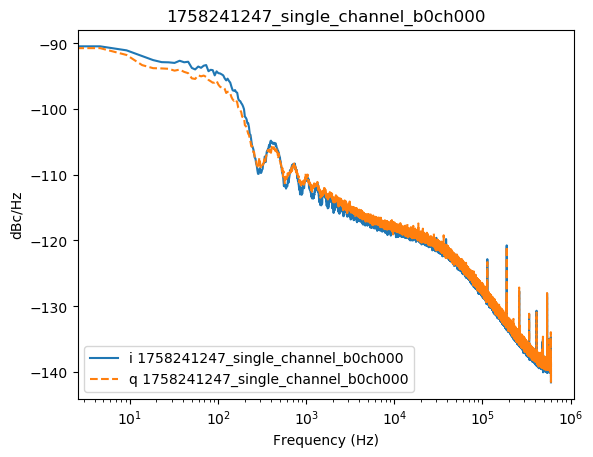

<Figure size 640x480 with 0 Axes>

CPU times: user 10.2 s, sys: 1.93 s, total: 12.1 s
Wall time: 1min 10s


In [21]:
%%time
iq1,_,filename=takeDebugData(S,band=band,channel=channel,nsamp=2**25,plot=True,channel_mode=1)

Here, acquisition took ~30sec as expected (2^25/(1.2e6) ~ 28 sec) and the noise agrees with the data taken in mode 0;

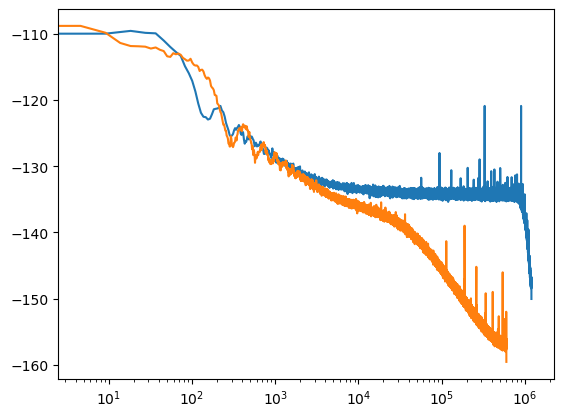

In [22]:
from scipy import ndimage

ffq0, pxxq0 = welch(iq.imag,fs=2.4e6, nperseg=2**18)
ffq1, pxxq1 = welch(iq1.imag,fs=1.2e6, nperseg=2**18)
plt.semilogx(ffq0,ndimage.median_filter(10*np.log10(pxxq0),size=1))
plt.semilogx(ffq1,ndimage.median_filter(10*np.log10(pxxq1),size=1))

If we want to take multichannel data, we should first configure the filter + downsample.  Here's how to set the filter for 10kHz;

In [23]:
S.set_debug_data_filter_cutoff(band, fcut_hz=10e3)

[ 2025-09-19 00:22:02 ]  Asked for a filter cut-off of 10000.000 Hz but got a cut-off of 9997.793 Hz due to rounding


Is filter being applied?

[ 2025-09-19 00:22:02 ]  caput smurf_server_s4:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[0]:readoutChannelSelect 0
[ 2025-09-19 00:22:02 ]  Writing to file : /data/smurf_data/20250919/1758241193/outputs/1758241322_single_channel_b0ch000.dat
[ 2025-09-19 00:22:02 ]  caput smurf_server_s4:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 33554432
[ 2025-09-19 00:22:02 ]  caput smurf_server_s4:AMCc:FpgaTopLevel:AppTop:AppCore:DebugSelect[0] 0
[ 2025-09-19 00:22:02 ]  Data acquisition in progress...
[ 2025-09-19 00:22:02 ]  caput smurf_server_s4:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:TriggerDaq 1
[ 2025-09-19 00:23:00 ]  Done taking data


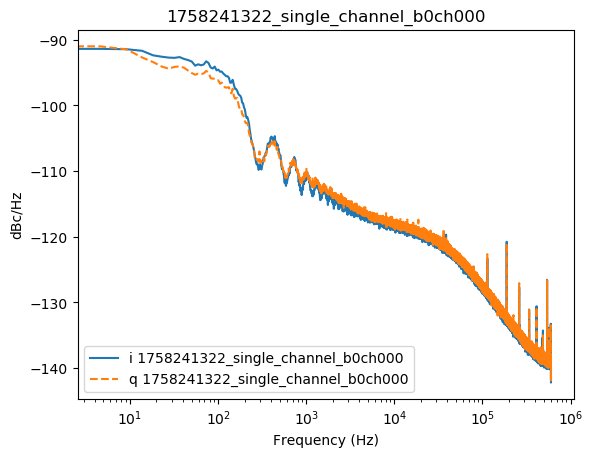

<Figure size 640x480 with 0 Axes>

CPU times: user 12 s, sys: 5.16 s, total: 17.2 s
Wall time: 1min 15s


In [24]:
%%time
iq1filt,_,filename=takeDebugData(S,band=band,channel=channel,nsamp=2**25,plot=True,channel_mode=1)

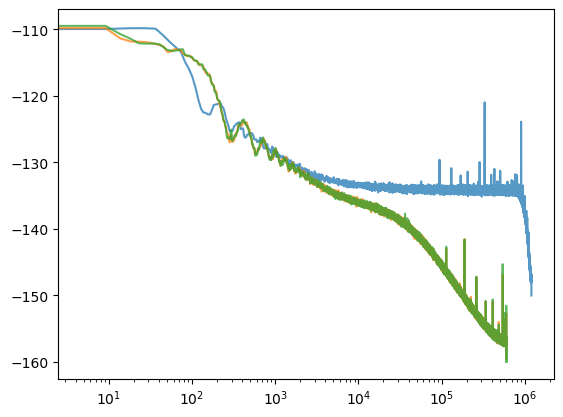

In [25]:
from scipy import ndimage

ffq1filt, pxxq1filt = welch(iq1filt.imag,fs=1.2e6, nperseg=2**18)
plt.semilogx(ffq0,ndimage.median_filter(10*np.log10(pxxq0),size=3),alpha=0.75)
plt.semilogx(ffq1,ndimage.median_filter(10*np.log10(pxxq1),size=3),alpha=0.75)
plt.semilogx(ffq1filt,ndimage.median_filter(10*np.log10(pxxq1filt),size=3),alpha=0.75)

Looks plausible.  Ok, so now should be able to decimate without incurring a noise penalty.  Let's try decimating to 30 kHz, or a factor of 40.  Must remember to adjust nsamp or your acq will take forever! 

In [29]:
S.set_decimation(band,39) # 39 is a decimation of 40, since the decimation is dec+1

[ 2025-09-19 00:23:37 ]  caput smurf_server_s4:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[0]:readoutChannelSelect 0
[ 2025-09-19 00:23:37 ]  Writing to file : /data/smurf_data/20250919/1758241193/outputs/1758241418_single_channel_b0ch000.dat
[ 2025-09-19 00:23:37 ]  caput smurf_server_s4:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 33554432
[ 2025-09-19 00:23:37 ]  caput smurf_server_s4:AMCc:FpgaTopLevel:AppTop:AppCore:DebugSelect[0] 0
[ 2025-09-19 00:23:37 ]  Data acquisition in progress...
[ 2025-09-19 00:23:37 ]  caput smurf_server_s4:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:TriggerDaq 1
[ 2025-09-19 00:24:20 ]  Done taking data


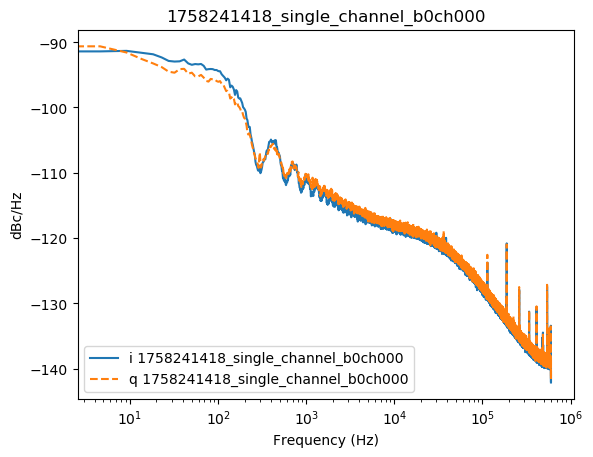

<Figure size 640x480 with 0 Axes>

CPU times: user 10.1 s, sys: 1.98 s, total: 12.1 s
Wall time: 54.4 s


In [30]:
%%time
iq1filtdec,_,filename=takeDebugData(S,band=band,channel=channel,nsamp=int(2**25/(S.get_decimation(band)+1)),plot=True,channel_mode=1)

/usr/local/lib/python3.8/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


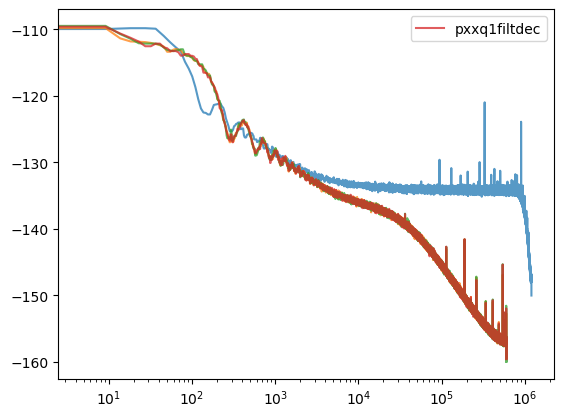

In [31]:
from scipy import ndimage

ffq1filtdec, pxxq1filtdec = welch(iq1filtdec.imag,fs=1.2e6/(S.get_decimation(band)+1), nperseg=2**18)
plt.semilogx(ffq0,ndimage.median_filter(10*np.log10(pxxq0),size=3),alpha=0.75)
plt.semilogx(ffq1,ndimage.median_filter(10*np.log10(pxxq1),size=3),alpha=0.75)
plt.semilogx(ffq1filt,ndimage.median_filter(10*np.log10(pxxq1filt),size=3),alpha=0.75)
plt.semilogx(ffq1filtdec,ndimage.median_filter(10*np.log10(pxxq1filtdec),size=3),alpha=0.75,label='pxxq1filtdec')
plt.legend()

In [33]:
print(pxxq1filtdec)
print(pxxq1filtdec.shape)
print(np.nonzero(pxxq1filtdec))

[3.10798428e-12 1.35698857e-11 1.09064678e-11 ... 2.08792388e-16
 1.95828878e-16 1.09105074e-16]
(131073,)
(array([     0,      1,      2, ..., 131070, 131071, 131072]),)


Ok, should be ready for multitone now.

# Multitone

For multitone, just don't pass a channel.  Remember your samples will get split across the 416 fw channels and increase accordingly.  Also be aware these files can get *big*

In [34]:
%%time
#iq1filtdecmultitone,_,filename=takeDebugData(S,band=band,channel=None,nsamp=int(S.get_number_processed_channels(band)*2**25/(S.get_decimation(band)+1)),plot=False)
iq1filtdecmultitone,_,filename=takeDebugData(S,band=band,channel=None,nsamp=2**25,plot=False)

[ 2025-09-19 00:26:02 ]  caput smurf_server_s4:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[0]:singleChannelReadout 0
[ 2025-09-19 00:26:02 ]  caput smurf_server_s4:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[0]:singleChannelReadoutOpt2 0
[ 2025-09-19 00:26:02 ]  Writing to file : /data/smurf_data/20250919/1758241193/outputs/1758241562_multi_channel_b0.dat
[ 2025-09-19 00:26:02 ]  caput smurf_server_s4:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 33554432
[ 2025-09-19 00:26:02 ]  caput smurf_server_s4:AMCc:FpgaTopLevel:AppTop:AppCore:DebugSelect[0] 0
[ 2025-09-19 00:26:02 ]  Data acquisition in progress...
[ 2025-09-19 00:26:02 ]  caput smurf_server_s4:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:TriggerDaq 1
[ 2025-09-19 00:26:04 ]  Done taking data
CPU times: user 6.68 s, sys: 2.47 s, total: 9.15 s
Wall time: 11.6 s


In [78]:
print(np.nonzero(iq1filtdecmultitone))
print(np.nonzero(iq1filtdecmultitone)[0].shape)
print(np.diff(np.nonzero(iq1filtdecmultitone)))
print(np.diff(np.nonzero(iq1filtdecmultitone))[0][:20])
iq1filtdecmultitone_nonzero = iq1filtdecmultitone[iq1filtdecmultitone != 0]

(array([     198,      415,      614, ..., 33553926, 33554143, 33554342]),)
(160781,)
[[217 199 217 ... 199 217 199]]
[217 199 217 199 217 199 217 199 217 199 217 199 217 199 217 199 217 199
 217 199]


In [79]:
print(iq1filtdecmultitone_nonzero[:10])

[3.43322754e-05+0.00000000e+00j 0.00000000e+00-3.45706940e-05j
 3.48091125e-05+0.00000000e+00j 0.00000000e+00-3.50475311e-05j
 3.52859497e-05+0.00000000e+00j 0.00000000e+00-3.55243683e-05j
 3.57627869e-05+0.00000000e+00j 0.00000000e+00-3.60012054e-05j
 3.62396240e-05+0.00000000e+00j 0.00000000e+00-3.64780426e-05j]


In [62]:
offset = 198+217
print(iq1filtdecmultitone[offset::416])

[0.-3.45706940e-05j 0.-3.50475311e-05j 0.-3.55243683e-05j ...
 0.-1.35898590e-05j 0.-1.40666962e-05j 0.-1.45435333e-05j]


/usr/local/lib/python3.8/dist-packages/scipy/signal/spectral.py:1961: UserWarning: nperseg = 262144 is greater than input length  = 80659, using nperseg = 80659
  warnings.warn('nperseg = {0:d} is greater than input length '


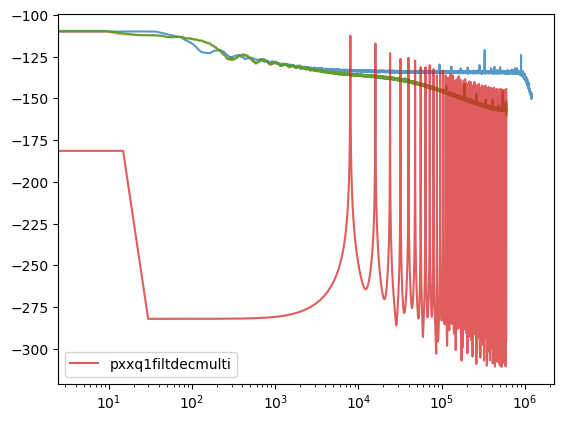

In [63]:
ffq1filtdecmultitone, pxxq1filtdecmultitone = welch(iq1filtdecmultitone.imag[offset::416],fs=1.2e6/(S.get_decimation(band)+1), nperseg=2**18)
plt.semilogx(ffq0,ndimage.median_filter(10*np.log10(pxxq0),size=3),alpha=0.75)
plt.semilogx(ffq1,ndimage.median_filter(10*np.log10(pxxq1),size=3),alpha=0.75)
plt.semilogx(ffq1filt,ndimage.median_filter(10*np.log10(pxxq1filt),size=3),alpha=0.75)
plt.semilogx(ffq1filtdecmultitone,ndimage.median_filter(10*np.log10(pxxq1filtdecmultitone),size=3),alpha=0.75,label='pxxq1filtdecmulti')
plt.legend()

In [39]:
print(pxxq1filtdecmultitone)
print(pxxq1filtdecmultitone.shape)
print(np.nonzero(pxxq1filtdecmultitone))

[0. 0. 0. ... 0. 0. 0.]
(40331,)
(array([], dtype=int64),)


Good.  Now let's do a true multitone measurement.

In [65]:
S.band_off(band)
chans=[]
for foff in [-225,-135,-17,0,94,196]:
    (_,chan)=S.set_fixed_tone(S.get_band_center_mhz(band)+foff,12)

Which channels are on?

In [66]:
S.which_on(band)

array([  0,  69, 159, 228, 394, 483])

Take multitone data...

In [67]:
%%time
#iq1filtdecmultitone,_,filename=takeDebugData(S,band=band,channel=None,nsamp=int(S.get_number_processed_channels(band)*2**25/(S.get_decimation(band)+1)),plot=False)
iq1filtdecmultitone2,_,filename=takeDebugData(S,band=band,channel=None,nsamp=2**24,plot=False)

[ 2025-09-19 22:04:09 ]  caput smurf_server_s4:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[0]:singleChannelReadout 0
[ 2025-09-19 22:04:09 ]  caput smurf_server_s4:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[0]:singleChannelReadoutOpt2 0
[ 2025-09-19 22:04:09 ]  Writing to file : /data/smurf_data/20250919/1758241193/outputs/1758319449_multi_channel_b0.dat
[ 2025-09-19 22:04:09 ]  caput smurf_server_s4:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 16777216
[ 2025-09-19 22:04:09 ]  caput smurf_server_s4:AMCc:FpgaTopLevel:AppTop:AppCore:DebugSelect[0] 0
[ 2025-09-19 22:04:09 ]  Data acquisition in progress...
[ 2025-09-19 22:04:09 ]  caput smurf_server_s4:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:TriggerDaq 1
[ 2025-09-19 22:04:11 ]  Done taking data
CPU times: user 2.52 s, sys: 1.75 s, total: 4.27 s
Wall time: 6.66 s


In [112]:
S.take_debug_data??

Signature:
S.take_debug_data(
    band,
    channel=None,
    nsamp=524288,
    filename=None,
    IQstream=1,
    single_channel_readout=1,
    debug=False,
    rf_iq=False,
    write_log=True,
)
Source:   
    @set_action()
    def take_debug_data(self, band, channel=None, nsamp=2**19, filename=None,
            IQstream=1, single_channel_readout=1, debug=False, rf_iq=False,
            write_log=True):
        """Takes raw debugging data.

        Args
        ----
        band : int
            The band to take data on.
        channel : int or None, optional, default None
            The channel to take debug data on in single_channel_mode.
        nsamp : int, optional, default 2**19
            The number of samples to take.
        filename : str or None, optional, default None
            The name of the file to save to.
        IQstream : int, optional, default 1
            Whether to take the raw IQ stream.
        single_channel_readout : int, optional, default 1
         

Hm, the array indices don't seem to line up with what I expect.  Compare;

In [68]:
S.which_on(band)

array([  0,  69, 159, 228, 394, 483])

In [73]:
np.nonzero(iq1filtdecmultitone2[:416])

(array([  8,  31,  64, 199, 271, 294, 351]),)

In [108]:
nonzero_imag = []
for chan in np.nonzero(iq1filtdecmultitone2)[0]:
    if iq1filtdecmultitone2[chan].imag != 0:
        nonzero_imag.append(chan)
print(nonzero_imag[:10])
print(np.diff(nonzero_imag))

[31, 447, 863, 1279, 1695, 2111, 2527, 2943, 3359, 3775]
[416 416 416 ... 416 416 416]


We may have found a SMuRF bug!

[0. 0. 0. ... 0. 0. 0.]


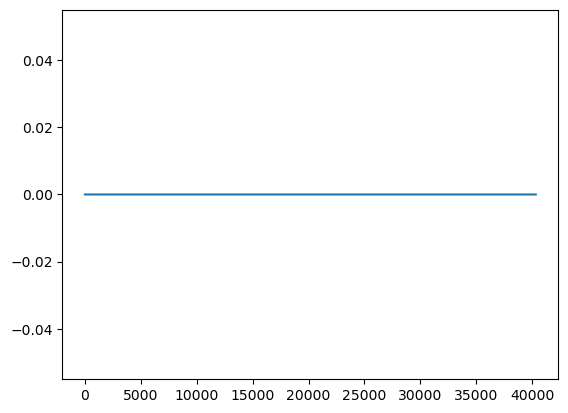

[2.45717746e-05 2.40949375e-05 2.36181003e-05 ... 3.55390293e-05
 3.50621921e-05 3.45853550e-05]


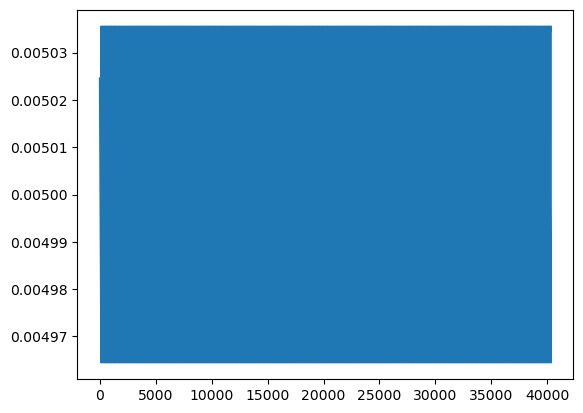

[0. 0. 0. ... 0. 0. 0.]


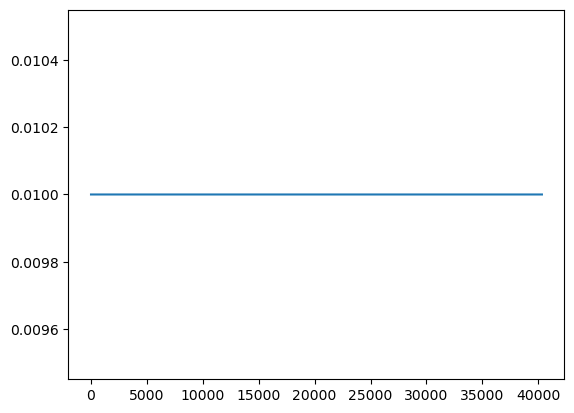

[0. 0. 0. ... 0. 0. 0.]


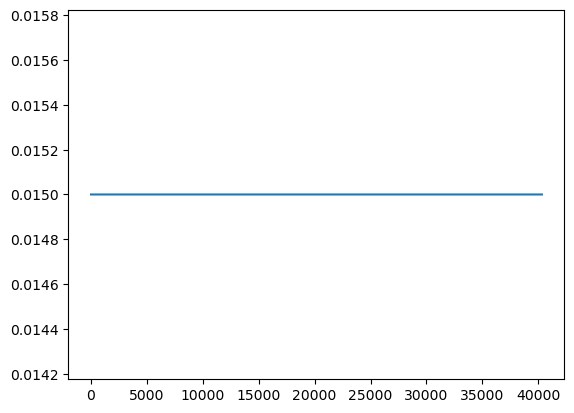

[0. 0. 0. ... 0. 0. 0.]


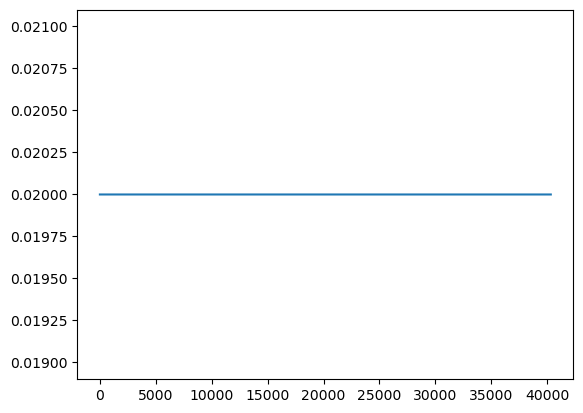

[0. 0. 0. ... 0. 0. 0.]


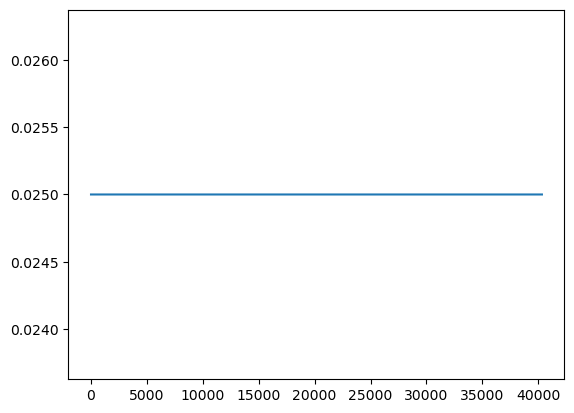

[0. 0. 0. ... 0. 0. 0.]


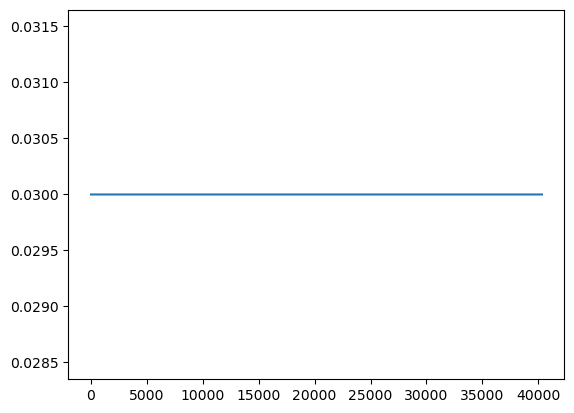

In [82]:
y_plotting_offset=0.005
for idx,chan in enumerate(np.nonzero(iq1filtdecmultitone2[:416])[0]):
    data=iq1filtdecmultitone2[chan::S.get_number_processed_channels(band)]
    print(data.imag-np.mean(data.imag))
    plt.plot(data.imag-np.mean(data.imag)+y_plotting_offset*idx,label=f'chan={chan}')
    plt.show()
#plt.plot(iq1filtdecmultitone2[56::416])
#plt.plot(iq1filtdecmultitone2[129::416])
#plt.legend()

In [71]:
data = iq1filtdecmultitone2[16]
datascaled = data.imag-np.mean(data.imag)
print(data)
print(datascaled)

0j
0.0
